# Gedik's algorithm with qudit encoding

In this notebook we implement Gedik's Algorithm (a quantum algorithm that provides computational speedup and solves a black-box problem), inspired by the following papers:

[1] Gedik, Zafer, et al. “Computational speed-up with a single qudit.” Scientific reports 5.1 (2015): 14671.

[2] Zhan, Xiang, et al. “Linear optical demonstration of quantum speed-up with a single qudit.” Optics Express 23.14 (2015): 18422-18427. 

## Introduction

This notebook is about implementing Gedik's Algorithm using Perceval. The specific algorithm is considered a Quantum Algorithm which tries to solve a problem by taking advantage of the attributes of a Quantum Computer. Gedik's algorithm is used to solve a black-box problem. The main task of the algorithm is to determine whether a specific permutation is clockwise or counterclockwise. This translates as a problem of finding the parity of the permutation. In order to implement the code efficiently, we used one qudit with 4 dimensions (ququart). 

Gedik's algorithm provides an example of a quantum algorithm that provides a speed-up compared to its classical implementation. This happens because in the classical case at least two function evaluations are required to find the parity of the permutation. For the quantum case only one function evaluation is enough to determine the parity of the permutation.

In [13]:
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
import perceval as pcvl
import perceval.components as comp
from perceval.algorithm import Sampler

The algorithm can be broken down in three parts. The Quantum Fourier Transform (QFT), the permutation operation and the inverse Quantum Fourier Transform.

## Permutation Operation

This part contains all the code that is necessary to implement all the different permutation types. We have eight different permutation operators that can be implemented in various ways using Perceval. The gates that we need to implement are the CNOT and the PAULI X.

In [14]:
# Because we used qudit encoding the CNOT gates can be implemented as unitaries. 
# We can also use Perceval's PERM function for the implementation.
# The following is the unitary of a CNOT gate.
cnot_m_01 = pcvl.Matrix([[1,0,0,0],
                         [0,1,0,0],
                         [0,0,0,1],
                         [0,0,1,0]])

# This is a CNOT gate with different control and target qubits.
cnot_m_10 = pcvl.Matrix([[1, 0, 0, 0],
                         [0, 0, 0, 1],
                         [0, 0, 1, 0],
                         [0, 1, 0, 0]])

cnot_01 = comp.Unitary(U = cnot_m_01)
cnot_10 = comp.Unitary(U = cnot_m_10)

In [15]:
# We can do the same with the X gates. We can implement them based on unitaries 
# Because of the qudit encoding XI or IX or XX must be implemented.
# We can also use PERM for the implementation as well.
X = np.array([[0,1],
              [1,0]])

XI_m = np.kron(X, np.eye(2))
XI_mp = pcvl.Matrix(XI_m)

IX_m = np.kron(np.eye(2), X)
IX_mp = pcvl.Matrix(IX_m)

XX_m = np.kron(X, X)
XX_mp = pcvl.Matrix(XX_m)

XI = comp.Unitary(U = XI_mp)
IX = comp.Unitary(U = IX_mp)
XX = comp.Unitary(U = XX_mp)

In [16]:
def perm(number, cnot, process):
    """
    Function that creates all the permutations in a Perceval's process encoding.
    Inputs:
        number (int): the number of the permutation.
        cnot (unitary): the type of CNOT to be used in the experiment.
        process (process): the process on which the permutations will be added.
    Outputs:
        process (process): the process that will contain all the permutations
    """
    
    if number == 1:
        process.add(0, cnot)
        process.add(0, IX)
    
    elif number == 2:
        process.add(0, XI)
    
    elif number == 3:
        process.add(0, cnot)
        process.add(0, XX)
        
    elif number == 4:
        process.add(0, cnot)
    
    elif number == 5:
        process.add(0, IX)
    
    elif number == 6:
        process.add(0, cnot)
        process.add(0, XI)
    
    elif number == 7:
        process.add(0, XX)
        
    print(f'Permutation {number}: Completed')
        
    return process

## Quantum Fourier Transform (QFT)

There are a lot of different ways to implement the QFT in Perceval. One of them is to decompose the QFT circuit to one-qubit gates and CNOTs in order to make it easier to apply. However, using the qudit encoding we can also implement the QFT using its unitary matrix.

In [17]:
# Implementation of QFT by using its unitary matrix.
# This works because we use qudit encoding.
qft = pcvl.Matrix([[1/2, 1/2, 1/2, 1/2],
                   [1/2, 1j/2, -1/2, -1j/2],
                   [1/2, -1/2, 1/2, -1/2],
                   [1/2, -1j/2, -1/2, 1j/2]])

qft_unit = comp.Unitary(U = qft)

## Inverse Quantum Fourier Transform (Inverse QFT)

The same holds for the Inverse QFT. It is not easy to be implemented in Perceval. However, using the qudit encoding it becomes much easier to make it work.

In [18]:
# Implementation of inverse QFT by using its unitary matrix.
inv_qft = qft.inv()

inv_qft_unit = comp.Unitary(U = inv_qft)

## Implementation of the process using Perceval

Creation of a process in Perceval in order to implement the Quantum Circuit needed for Gedik's Algorithm. All the necessary gates will be added to the specific process.

We have to define the input state that will be used in the process. 
With the qudit encoding the input state will be different from the regular qubit encoding.
The mapping will be as follows.

$|00\rangle$: $|1,0,0,0\rangle$ 

$|01\rangle$: $|0,1,0,0\rangle$ 

$|10\rangle$: $|0,0,1,0\rangle$ 

$|11\rangle$: $|0,0,0,1\rangle$ 

For Gedik's Algorithm the input state must be the $|01\rangle$ state. 

In [19]:
def algo_proc(perm_no, qft_ver, inv_qft_ver):
    """
    Function that implements Gedik's algorithm in a non-noisy simulator.
    Gives us the theoretical results. Useful because we will compare them with experimental.
    Inputs: 
        perm_no (int): the number of the permutation that we want to test.
        qft (unitary): the type of the QFT to be used.
        inv_qft (unitary): the type of the inverse QFT to be used.
    Outputs: 
        res (dict): the result of the sim process with probs.
    """ 
    assert perm_no in range(8), 'perm_no can take values from 0 to 7.'
    
    pr = pcvl.Processor("SLOS", 4)
    
    # Add the QFT procedure in the process.
    pr.add(0, qft_ver)
    
    # Add the permutation operator that has to be checked, by choosing a number between 0 and 7.
    # The first four correspond to plus permutations and (theoretically) we expect them to return |01> 
    # while the other four correspond to minus permutations and (theoretically) we expect them to return |11>.
    perm(perm_no, cnot_10, pr)
    
    # The final part of Gedik's algorithm is to insert the inverse QFT procedure.
    pr.add(0, inv_qft_ver)
    
    input_state = pcvl.BasicState([0,1,0,0])
    
    pr.with_input(input_state)
    
    res = pr.probs()['results']
    
    return res

In [20]:
# Run the circuit using as the initial state the one that was defined above.
for i in range(8):
    print(algo_proc(i, qft_unit, inv_qft_unit))

Permutation 0: Completed
{
  |0,1,0,0>: 1.0
}
Permutation 1: Completed
{
  |0,1,0,0>: 1.0
}
Permutation 2: Completed
{
  |0,1,0,0>: 1.0
}
Permutation 3: Completed
{
  |0,1,0,0>: 1.0
}
Permutation 4: Completed
{
  |0,0,0,1>: 1.0
}
Permutation 5: Completed
{
  |0,0,0,1>: 1.0
}
Permutation 6: Completed
{
  |0,0,0,1>: 1.0
}
Permutation 7: Completed
{
  |0,0,0,1>: 1.0
}


## Try the implementation of the algorithm in a noisy simulator

We will use Quandela's remote processor in order to let Gedik's algorithm run in a noisy simulator. 
This will help us have a better look regarding the efficiency of the implementation. In this section we will use a simulator of the QPU that is provided via "sim:ascella".

In [21]:
# Save your token into Perceval persistent data, you only need to do it once.
pcvl.save_token("MY_TOKEN")

remote_pr = pcvl.RemoteProcessor("sim:ascella")

In [22]:
# Define the physical parameters that we need.
remote_pr.set_parameters({
    "HOM": .95,
    "transmittance": .1,
    "g2": .01
})
remote_pr.min_detected_photons_filter(1)

# Add all the necessary components to the processor.
# We can try different permutations by modifying the number variable of the perm function.
# The numbers that are valid are from 0 to 7.
remote_pr.add(0, qft_unit)
perm(3, cnot_10, remote_pr)
remote_pr.add(0, inv_qft_unit)

Permutation 3: Completed


In [23]:
# Define and run the processor with the predefined input state
input_state = pcvl.BasicState([0,1,0,0])

remote_pr.with_input(input_state)

In [24]:
# We can use the sampler module in order to get the results of the algorithm.
sampler = Sampler(remote_pr)
sampler.default_job_name = "Gediks_Algo"

nsample = 100000
remote_job = sampler.sample_count.execute_async(nsample)

In [26]:
# Get the results once they are available after the completion of sampling.
while not remote_job.status.completed:
    sleep(1)
results = remote_job.get_results()
print(results['results'])

{
  |0,1,0,0>: 100000
}


We will use Quandela's remote processor in order to let Gedik's algorithm run in a noisy simulator. This will help us have a better look regarding the efficiency of the implementation. In this section we will use the actual QPU that is provided via "qpu:ascella".

In [28]:
remote_qpu = pcvl.RemoteProcessor("qpu:ascella")

def algo_qpu(perm_no, qft_ver, inv_qft_ver):
    """
    Function that implements Gedik's algorithm with a format that will be run on the QPU.
    Inputs: 
        perm_no (int): the number of the permutation to be added.
        qft (unitary): the unitary that will implement the QFT procedure.
        inv_qft (unitary): the unitary that will implement the inverse QFT procedure.
        token (str): the token to implement the experiment in the QPU.
    Outputs:
        remote_job_qpu: creates a remote job object that will be used to run the 
            experiments on the QPU
    """
    remote_qpu.clear_input_and_circuit()
    remote_qpu.add(0, qft_ver)
    perm(perm_no, cnot_10, remote_qpu)
    remote_qpu.add(0, inv_qft_ver)
    
    input_state = pcvl.BasicState([0,1,0,0])

    remote_qpu.with_input(input_state)
    
    sampler_on_qpu = Sampler(remote_qpu)

    nsample = 200000
    remote_job_qpu = sampler_on_qpu.sample_count  
    remote_job_qpu.name = "Gediks_Algo_QPU"
    remote_job_qpu.execute_async(nsample)
    
    return remote_job_qpu

In [39]:
# Run the algorithm on the QPU for all the permutations
jobs = []
for i in range(8):
    jobs.append(algo_qpu(i, qft_unit, inv_qft_unit))

Permutation 0: Completed
Permutation 1: Completed
Permutation 2: Completed
Permutation 3: Completed
Permutation 4: Completed
Permutation 5: Completed
Permutation 6: Completed
Permutation 7: Completed


In [41]:
# Get the results once they are available
data_qpu = []
for i in range(8):
    while not jobs[i].status.completed:
        sleep(1)
    data_qpu.append(jobs[i].get_results()['results'])

In [ ]:
# Transform the results returned from Ascella to percentages to add them to 
# plots and compare them with the non-noisy results.
data_qpu_prob = []
for res_qpu in data_qpu:
    total = sum(res_qpu.values())
    res_qpu_dict = {k: v / total for k, v in res_qpu.items()}
    data_qpu_prob.append(res_qpu_dict)

## Create Plots

Modify the data from the results in order to plot it properly.

In [ ]:
# Create a state map that maps the results that from Perceval using the qudit encoding 
# with the states in the qubit encoding.
state_map = {
        '|1,0,0,0>': '00',
        '|0,1,0,0>': '01',
        '|0,0,1,0>': '10',
        '|0,0,0,1>': '11'
        }

# Run the algorithm with all the permutations and store the results.
data_n = []
for i in range(8):
    data_n.append(algo_proc(i, qft_unit, inv_qft_unit))

Permutation 0: Completed
Permutation 1: Completed
Permutation 2: Completed
Permutation 3: Completed
Permutation 4: Completed
Permutation 5: Completed
Permutation 6: Completed
Permutation 7: Completed


In [ ]:
def cr_data(res_map, st_map):
    """
    Function that is used to map the states with qudit encoding to the ones with qubit encoding
    and also add the probabilities of each state after the completion of the algorithm.
    Inputs: 
        res_map (dict): dictionary that contains all the data from the experiments.
        state_map (dict): a dictionary that contains a mapping between Fock space states (in qudit encoding)
            and Hilbert space states in qubit encoding. 
    Outputs:
        dict_f (dict): a dictionary containing all possible states in qubit encoding and their respective
            probabilities of occurrence.
    """
    dict_f = {'00': 0,
              '01': 0,
              '10': 0,
              '11': 0}

    for k,v in res_map.items():
        for state in st_map.keys():
            if str(k) == state:
                dict_f[state_map[str(k)]] += v

    return dict_f

In [ ]:
# Use of cr_data function in order to modify the data for all the permutations in order to make it ready for plotting.
data_plt = []
for i in range(8):
    data_plt.append(cr_data(data_n[i], state_map))
    
data_plt_qpu = []
for i in range(8):
    data_plt_qpu.append(cr_data(data_qpu_prob[i], state_map))

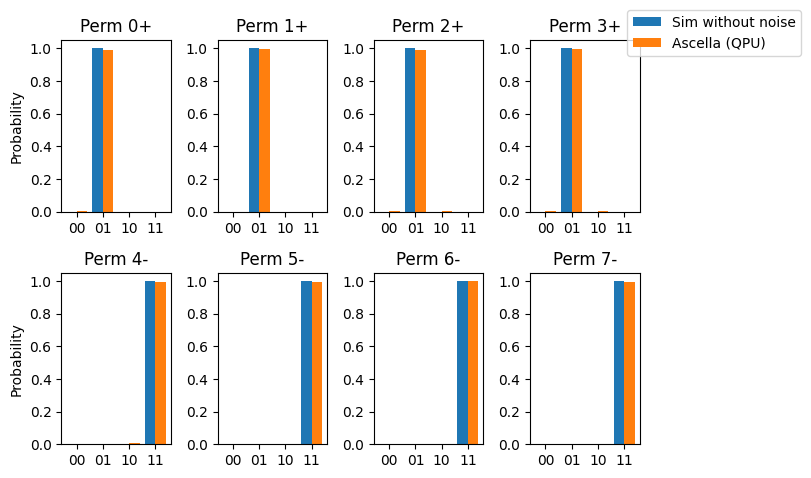

In [ ]:
# Create subplots for the results of all the permutations after applying Gedik's algorithm.
# The results are identical to those from the paper.
width = 0.4
r = np.arange(len(data_plt[0].keys()))

fig, axs = plt.subplots(2, 4)
for i in range(8):
    a = i // 4
    b = i - 4 * a
    l1 = axs[a, b].bar(r - 0.2, data_plt[i].values(), width=width)
    l2 = axs[a, b].bar(r + 0.2, data_plt_qpu[i].values(), width=width)
    axs[a, b].set_title(f'Perm {i}+')

fig.tight_layout()

plt.setp(axs, xticks=r, xticklabels=data_plt[0].keys())

axs[0,0].set(ylabel='Probability')
axs[1,0].set(ylabel='Probability')

fig.legend(('Sim without noise', 'Ascella (QPU)'), bbox_to_anchor=(1.24, 1))

## References

[1] Gedik, Zafer, et al. "Computational speed-up with a single qudit." Scientific reports 5.1 (2015): 14671.

[2] Zhan, Xiang, et al. "Linear optical demonstration of quantum speed-up with a single qudit." Optics Express 23.14 (2015): 18422-18427.